# Dogs vs Cats Redux

In this notebook, we will explore how we can use a pre-trained VGG network to classify images as either dogs or cats. We will then submit our predictions to this kaggle competition:

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

**DISCLAIMER**

This notebook utilizes the pre-built vgg16.py and utils.py which was created by fast.ai. This DOES NOT use the keras inbuilt VGG model. Future notebooks explore the inbuilt models.

Reference : https://github.com/fastai/courses/tree/master/deeplearning1/nbs

In [1]:
from importlib import reload
import utils; reload(utils)
from utils import *
from PIL import Image

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Using TensorFlow backend.


In [2]:
# Here we import a pretrained VGG model. 
# Courtesy : https://github.com/fastai/courses/tree/master/deeplearning1/nbs

import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

## Directory structure of the data

In Keras, for image recognition/classification, we need to arrange the data in a certain structure. Images from each category for training must be placed in a separate folder. 

Here, we have two separate folders 'cats' and 'dogs' each of which contains training examples belonging to that class. We do the same for validation set. 

Since the test set examples are unlabeled (as we are to predict them), we put all those examples into an 'unknown' folder.

NOTE : This fixed directory structure was created from the command line and this code for it is not present in this notebook

In [4]:
% ls data/dogscatsredux/

results/  sample/  sample_submission.csv  test/  train/  valid/


In [5]:
path = 'data/dogscatsredux/'
#path = 'data/dogscatsredux/sample/'

In [6]:
% ls 'data/dogscatsredux/test'

unknown/


In [7]:
% ls 'data/dogscatsredux/train'

cats/  dogs/


In [8]:
% ls 'data/dogscatsredux/valid'

cats/  dogs/


Let us now see a few of these images

In [9]:
%ls -U 'data/dogscatsredux/train/cats' | head -4

cat.8760.jpg
cat.710.jpg
cat.1069.jpg
cat.11298.jpg
ls: write error


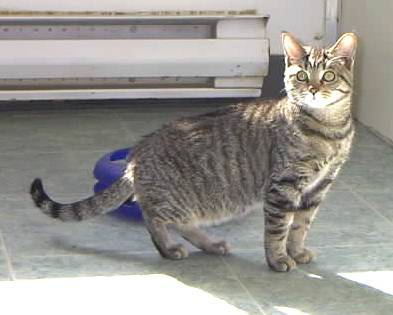

In [10]:
ex_path = path+'train/cats/'
Image.open(ex_path + 'cat.8760.jpg')

As we can see, the directory structure is in the format needed by keras

## Traning and Testing 

In [11]:
# Let us start using the pretrained VGG model

vgg = Vgg16()

In [12]:
??vgg.get_batches

If we look at the get_batches() method in vgg16.py we see that it takes :
- a path to the set from which you want to generate the batches, 
- an ImageDataGenerator object (which generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely) --> this is created in the function declaration itself
- whether batches should be shuffled or not
- size of the batch
- and the class mode

What this method does is, it internally calls the inbuilt flow_from_directory method of keras. This method the path to a directory, and generates batches of augmented/normalized data. It yields batches indefinitely, in an infinite loop.

Reference : https://keras.io/preprocessing/image/


In [13]:
batch_size = 64

In [14]:
train_batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Let us look at the type of the returned values of the get_bacthes method

In [15]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [16]:
print(len(vgg.classes))
vgg.classes[0:5]

1000


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

As we can see, the VGG model was trained on the imagenet database which contains 1000 categories of images. If we predict directly using this model, without any changes, then for each test example, we would get 1000 probabilities, each pertaining to the classes in the dataset.

This is not what we want here. Here we just want the model to output 2 probabilities, related to cats and dogs

As such, in vgg16.py we have defined a 'finetune' method which takes care of adapting the VGG model to the task at hand.

The finetune method calls the 'ft' method internally. This method removes the last layer of the VGG model (which was a final softmax dense layer with output as 1000 dimensions). After that, it sets all the layers to be trainable as false since we do not want the model to learn anything new. It then adds a new sofmax dense layer with output as 2 in this case, pertaining to cats and dogs.

In [17]:
??vgg.finetune

In [18]:
??vgg.ft

In [19]:
vgg.finetune(train_batches)

In [20]:
vgg.model.optimizer.lr = 0.01

After finetuning the VGG model to predict only 'cats' and 'dogs', we then train just the last newly added layer ( remember, we had set all others to be NOT trainable)

The fit() method internally calls the fit_generator() method of keras which filts the model on data generated batch-by-batch by a Python generator.

Reference : https://keras.io/models/sequential/

In [23]:
vgg.fit(train_batches,val_batches,batch_size=1024,nb_epoch=20)

Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 1.6330 - acc: 0.8633 - val_loss: 1.0657 - val_acc: 0.8984
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 1.3508 - acc: 0.8844 - val_loss: 1.3214 - val_acc: 0.8891
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 1.4571 - acc: 0.8914 - val_loss: 1.2535 - val_acc: 0.8984
Epoch 4/20
20/20 [==============================] - 25s 1s/step - loss: 1.1604 - acc: 0.9031 - val_loss: 1.1138 - val_acc: 0.9062
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 1.5120 - acc: 0.8719 - val_loss: 1.1343 - val_acc: 0.9047
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 1.7546 - acc: 0.8547 - val_loss: 1.4964 - val_acc: 0.8781
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 1.5545 - acc: 0.8742 - val_loss: 1.3151 - val_acc: 0.8953
Epoch 8/20
20/20 [==============================] - 23s 1s/step - loss: 1.6782 - acc: 0.87

We now call vgg.test() method which internally calls the predict_generator() method of Keras. It generates predictions for the input samples from a data generator.

Reference : https://keras.io/models/sequential/

In [24]:
test_batches, test_predictions = vgg.test(path+'test', batch_size=batch_size)

Found 12500 images belonging to 1 classes.
196/196 [==============================] - 141s 719ms/step


Now we see that test_predictions generates probabilities for the image being either a cat or a dog

In [25]:
test_predictions

array([[  0.0000e+00,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   9.9784e-21],
       ..., 
       [  0.0000e+00,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   1.9534e-25]], dtype=float32)

In [26]:
train_batches.class_indices

{'cats': 0, 'dogs': 1}

In [27]:
% cat 'data/dogscatsredux/sample_submission.csv'

id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5
7,0.5
8,0.5
9,0.5
10,0.5
11,0.5
12,0.5
13,0.5
14,0.5
15,0.5
16,0.5
17,0.5
18,0.5
19,0.5
20,0.5
21,0.5
22,0.5
23,0.5
24,0.5
25,0.5
26,0.5
27,0.5
28,0.5
29,0.5
30,0.5
31,0.5
32,0.5
33,0.5
34,0.5
35,0.5
36,0.5
37,0.5
38,0.5
39,0.5
40,0.5
41,0.5
42,0.5
43,0.5
44,0.5
45,0.5
46,0.5
47,0.5
48,0.5
49,0.5
50,0.5
51,0.5
52,0.5
53,0.5
54,0.5
55,0.5
56,0.5
57,0.5
58,0.5
59,0.5
60,0.5
61,0.5
62,0.5
63,0.5
64,0.5
65,0.5
66,0.5
67,0.5
68,0.5
69,0.5
70,0.5
71,0.5
72,0.5
73,0.5
74,0.5
75,0.5
76,0.5
77,0.5
78,0.5
79,0.5
80,0.5
81,0.5
82,0.5
83,0.5
84,0.5
85,0.5
86,0.5
87,0.5
88,0.5
89,0.5
90,0.5
91,0.5
92,0.5
93,0.5
94,0.5
95,0.5
96,0.5
97,0.5
98,0.5
99,0.5
100,0.5
101,0.5
102,0.5
103,0.5
104,0.5
105,0.5
106,0.5
107,0.5
108,0.5
109,0.5
110,0.5
111,0.5
112,0.5
113,0.5
114,0.5
115,0.5
116,0.5
117,0.5
118,0.5
119,0.5
120,0.5
121,0.5
122,0.5
123,0.5
124,0.5
125,0.5
126,0.5
127,0.5
128,0.5
129,0.5
130,0.5
131,0.5
132,0.5
133,0.5
134,0.5
135,0.5
136,0.5
137,0.5
138

Now, from the kaggle competition page, we know that for each image in the test set, we should predict a probability that the image is a dog (1 = dog, 0 = cat).

In [28]:
test_prediction_dog = [test_predictions[i][1] for i in range(len(test_predictions))]

In [29]:
test_prediction_dog

[1.0,
 0.0,
 9.9784453e-21,
 1.0,
 0.99999821,
 0.0,
 0.0,
 1.0,
 3.5993566e-13,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.5199378e-19,
 1.0,
 0.11713167,
 0.0,
 1.159375e-14,
 3.7092875e-09,
 1.0,
 5.52903e-34,
 0.0,
 0.0,
 0.0,
 1.0,
 1.1139236e-35,
 0.0,
 1.0,
 1.0,
 0.99999738,
 1.0,
 1.0,
 1.0,
 0.0,
 3.5993725e-08,
 1.0,
 1.0,
 0.0,
 7.6941588e-17,
 1.0777131e-21,
 1.2666388e-14,
 2.2438495e-38,
 1.0,
 2.044971e-11,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.99973625,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 6.7970223e-38,
 0.0,
 0.0,
 1.0,
 0.0,
 2.9602915e-25,
 1.0,
 6.523121e-26,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 7.3577464e-31,
 1.0,
 1.0,
 1.9031578e-34,
 0.0,
 3.4428958e-30,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.9767297e-08,
 5.4073101e-30,
 3.7081896e-36,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.8790099e-30,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9999975,
 0.0,
 1.0,
 8.6884312e-20,
 1.0,
 4.7622128e-12,
 0.0,
 1.0,
 

Let us assert and see if our test_prediction_dogs and our overall test_predictions have the same number of entries

In [30]:
assert(len(test_prediction_dog ) == len(test_predictions))

Now we need to add the column_names id,label as the first row

We can use the filenames() method of the batch iterator of the test set to get the ids

In [31]:
test_batches.filenames

['unknown/1.jpg',
 'unknown/10.jpg',
 'unknown/100.jpg',
 'unknown/1000.jpg',
 'unknown/10000.jpg',
 'unknown/10001.jpg',
 'unknown/10002.jpg',
 'unknown/10003.jpg',
 'unknown/10004.jpg',
 'unknown/10005.jpg',
 'unknown/10006.jpg',
 'unknown/10007.jpg',
 'unknown/10008.jpg',
 'unknown/10009.jpg',
 'unknown/1001.jpg',
 'unknown/10010.jpg',
 'unknown/10011.jpg',
 'unknown/10012.jpg',
 'unknown/10013.jpg',
 'unknown/10014.jpg',
 'unknown/10015.jpg',
 'unknown/10016.jpg',
 'unknown/10017.jpg',
 'unknown/10018.jpg',
 'unknown/10019.jpg',
 'unknown/1002.jpg',
 'unknown/10020.jpg',
 'unknown/10021.jpg',
 'unknown/10022.jpg',
 'unknown/10023.jpg',
 'unknown/10024.jpg',
 'unknown/10025.jpg',
 'unknown/10026.jpg',
 'unknown/10027.jpg',
 'unknown/10028.jpg',
 'unknown/10029.jpg',
 'unknown/1003.jpg',
 'unknown/10030.jpg',
 'unknown/10031.jpg',
 'unknown/10032.jpg',
 'unknown/10033.jpg',
 'unknown/10034.jpg',
 'unknown/10035.jpg',
 'unknown/10036.jpg',
 'unknown/10037.jpg',
 'unknown/10038.jpg',
 

In [32]:
ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])

In [33]:
ids

array([   1,   10,  100, ..., 9997, 9998, 9999])

We can use the stack() method of numpy to join the ids and labels as two columns

In [34]:
submission = np.stack([ids,test_prediction_dog], axis=1)

In [35]:
#checking last 4 entries
submission[-4:]

array([[  9.9960e+03,   1.0000e+00],
       [  9.9970e+03,   1.0000e+00],
       [  9.9980e+03,   0.0000e+00],
       [  9.9990e+03,   1.9534e-25]])

In [36]:
%pwd

'/home/kshitijg1992/fastai/courses/deeplearning1/nbs'

In [37]:
submission_file_name = path + 'results/'+'submission1.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

In [38]:
%ls 'data/dogscatsredux/results'

submission1.csv  submission2.csv



## Results

This submission on Kaggle resulted in a log loss of 0.25679 while the best submission had a log loss of 0.03302. 

Clearly, we can do better!

Now, since we have a valiadtion set, let us see how well we do on our validation set.

In [39]:
validation_testing_batches, validation_predictions = vgg.test(path+'valid', batch_size=batch_size)

Found 5000 images belonging to 2 classes.
79/79 [==============================] - 57s 717ms/step


In [40]:
validation_predictions

array([[  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       ..., 
       [  0.0000e+00,   1.0000e+00],
       [  1.0000e+00,   4.7521e-16],
       [  0.0000e+00,   1.0000e+00]], dtype=float32)

Let us get the labels of our predictions on the validation set

In [41]:
validation_prediction_labels= np.argmax(validation_predictions,axis=1)

In [42]:
validation_prediction_labels

array([0, 0, 0, ..., 1, 0, 1])

In [43]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/' + validation_testing_batches.filenames[i]) for i in idx], titles=titles)
    

In order to better understand what is happening, let us look at these particular examples :

- A few correct labels at random
- A few incorrect labels at random
- The most correct labels of each class (ie those with highest probability that are correct)
- The most incorrect labels of each class (ie those with highest probability that are incorrect)
- The most uncertain labels (ie those with probability closest to 0.5).

### A few correct labels

In [44]:
%matplotlib inline

In [45]:
prediction_prob_cat = validation_predictions[:,0]

In [46]:
actual_labels = validation_testing_batches.classes

In [47]:
correct_preds = (validation_prediction_labels == actual_labels).astype(int)
correct_preds = np.where(correct_preds == 1)[0]

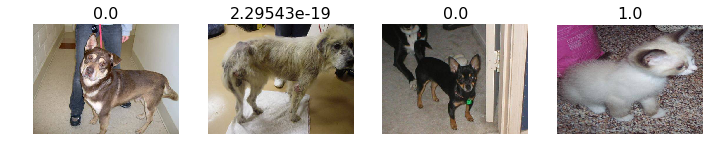

In [48]:
# Let us take 4 correct predictions at random
idx = np.random.permutation(correct_preds)[0:4]
plots_idx(idx, prediction_prob_cat[idx])

Figure on top of image shows the probability of that image being a cat

### A few incorrect labels

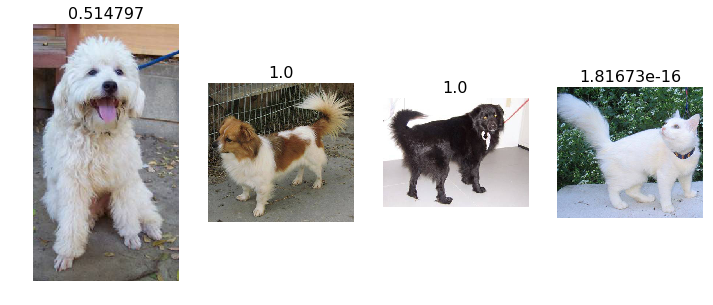

In [49]:
incorrect_preds = (validation_prediction_labels == actual_labels).astype(int)
incorrect_preds = np.where(incorrect_preds == 0)[0]
idx = np.random.permutation(incorrect_preds)[0:4]
plots_idx(idx, prediction_prob_cat[idx])

If we look at the incorrect predictions above, we can try and reason why the model classified these incorrectly

- For the first iamge, the dog is against a white background with some glare from the eyes.
- For the second image, we cannot see the face of the dog. We are looking at the animal at a different angle.
- For the third image, we just see the face of the dog against a background. The classifier was only 58% sure it was a dog
- The last image makes it very clear why our model predicted incorrectly. The cat somehow is getting camouflaged against the background

### The most correct labels of the cat class (ie those with highest probability that are correct)

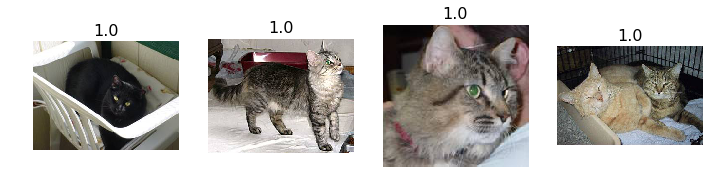

In [50]:
correct_preds_t = ((validation_prediction_labels == actual_labels) & (actual_labels ==0)).astype(int)
correct_preds = np.where(correct_preds_t == 1)[0]
idx = np.argsort(prediction_prob_cat[correct_preds])[::-1][:4]
plots_idx(correct_preds[idx], prediction_prob_cat[correct_preds][idx])

As we can see above, the most correct predictions are for those images where we have the front angle for the cat and its features can be easily distinguished against the bachground

### The most correct labels of the dog class (ie those with highest probability that are correct)

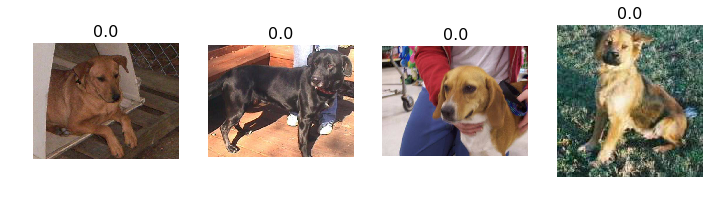

In [51]:
correct_preds_t = ((validation_prediction_labels == actual_labels) & (actual_labels ==1)).astype(int)
correct_preds = np.where(correct_preds_t == 1)[0]
idx = np.argsort(prediction_prob_cat[correct_preds])[:4]
plots_idx(correct_preds[idx], prediction_prob_cat[correct_preds][idx])

### The most incorrect labels of cat class (ie those with highest probability that are incorrect)

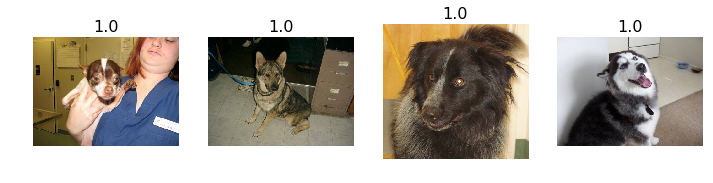

In [52]:
correct_preds_t = ((validation_prediction_labels == actual_labels) & (actual_labels ==0)).astype(int)
correct_preds = np.where(correct_preds_t == 0)[0]
idx = np.argsort(prediction_prob_cat[correct_preds])[::-1][:4]
plots_idx(correct_preds[idx], prediction_prob_cat[correct_preds][idx])

As we see from the above images, the model is classifying above dogs as cats with probability of almost 1. If we look at the first two images, they are of very small dogs. The third image has a side angle of a dog while in the fourth one the dog's features are not easily distinguishable since it is behind a cage.

### The most incorrect labels of dog class (ie those with highest probability that are incorrect)

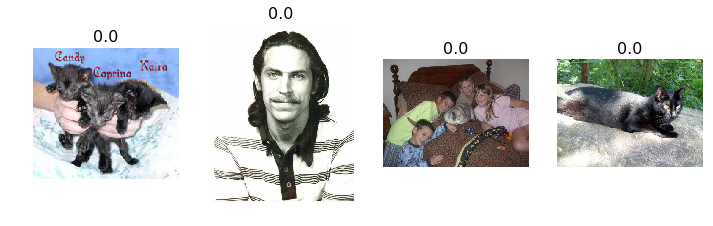

In [53]:
correct_preds_t = ((validation_prediction_labels == actual_labels) & (actual_labels ==1)).astype(int)
correct_preds = np.where(correct_preds_t == 0)[0]
idx = np.argsort(prediction_prob_cat[correct_preds])[:4]
plots_idx(correct_preds[idx], prediction_prob_cat[correct_preds][idx])

As seen from the above figure, the model says that the above figures are cats with almost 0% probability, i.e. it is extremely sure that they are dogs. If we look at the first image, we see that there are a lot of objects in the image and the cat's fur sort of blends into the background. For the third image, the cat's fur is indistinguishable and we dont see a lot of distinguishing marks. The last picture is of multiple kitten together which might confuse the model.

### Performance metrics

Now that we have seen some of the above cases, we can see the performance metrics of the model

In [54]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [55]:
print(classification_report(y_pred=validation_prediction_labels, y_true=actual_labels))
print(accuracy_score(y_pred=validation_prediction_labels, y_true=actual_labels))
print(confusion_matrix(y_pred=validation_prediction_labels,y_true=actual_labels))

             precision    recall  f1-score   support

          0       0.89      0.93      0.91      2500
          1       0.93      0.89      0.91      2500

avg / total       0.91      0.91      0.91      5000

0.9106
[[2337  163]
 [ 284 2216]]


[[2337  163]
 [ 284 2216]]


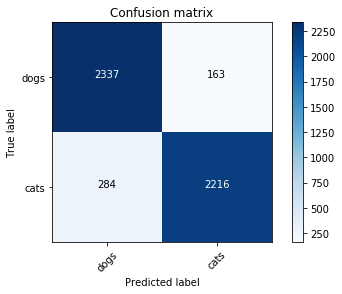

In [56]:
plot_confusion_matrix(confusion_matrix(y_pred=validation_prediction_labels,y_true=actual_labels),\
                                       validation_testing_batches.class_indices)

We see from the above metrics on the validation set, that we get an accuracy of 92.8%. We have also plotted the confusion matrix.

This however does not seem to be the reason why we got such a huge log-loss value. On more research, it was found that Log-Loss doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). 

Reference : https://goo.gl/3skCnp

#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05

In [57]:
temp = np.array(test_prediction_dog)
test_prediction_dog_clipped = temp.clip(min=0.05, max=0.95)

In [58]:
test_prediction_dog_clipped

array([ 0.95,  0.05,  0.05, ...,  0.95,  0.05,  0.05], dtype=float32)

In [59]:
submission2 = np.stack([ids,test_prediction_dog_clipped], axis=1)

In [60]:
submission_file_name = path + 'results/'+'submission2.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

In [61]:
%ls 'data/dogscatsredux/results'

submission1.csv  submission2.csv
